In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
!pip install tslearn
from tslearn.metrics import cdist_dtw
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import pywt
import geopandas as gpd
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy.stats import mode
from collections import defaultdict
from tqdm import tqdm  # optional for progress bar

In [2]:
optimal_cluster = 'st_cluster_3_5_7'
save=True
simulate = False

# Load Geospatial

In [3]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Load Claims

In [4]:
clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")
clustered_claims['countyCode']=clustered_claims['countyCode'].apply(lambda x: str(x).zfill(5))
clustered_claims['stateCode']=clustered_claims['countyCode'].str[:2]

/tmp/ipykernel_705/224045918.py:1: DtypeWarning: Columns (7,25,32,35,38,42,51,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")


In [5]:
# Create the new field 'percentageDamageAmount'
clustered_claims['percentageBuildingDamageAmount'] = ((clustered_claims['buildingDamageAmount'] / clustered_claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
clustered_claims['totalClaimPaid'] = clustered_claims['amountPaidOnBuildingClaim'].fillna(0) + clustered_claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
clustered_claims = clustered_claims[clustered_claims['stateOwnedIndicator'] != True]

In [6]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 
#CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/CPI_by_Year_Month.csv") for homeowners insurance CPI

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
clustered_claims.loc[:, 'yearOfLoss'] = clustered_claims['dateOfLoss'].dt.year

# Merge clustered_claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(clustered_claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

clustered_claims = claims_merged

/tmp/ipykernel_705/1551299827.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_705/1551299827.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_705/1551299827.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an in

In [7]:
# Katrina
katrina = 4
katrina_numbers =[4520, 1707, 1561, 1246, 2187, 1481] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: katrina if x in katrina_numbers else x
)

# Sandy
sandy = 87
sandy_numbers =[1603, 1507, 1252] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: sandy if x in sandy_numbers else x
)

# Harvey
harvey = 327
harvey_numbers =[3430, 5719, 5614, 5712, 5678, 5611, 1456, 1736] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: harvey if x in harvey_numbers else x
)

# Ian
ian = 166
ian_numbers =[3907, 4050] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ian if x in ian_numbers else x
)

# ike
ike = 8
ike_numbers =[222, 1559, 1419] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ike if x in ike_numbers else x
)

# la_2016
la_2016 = 295
la_2016_numbers =[3731, 2086, 2053, 3617, 3557] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: la_2016 if x in la_2016_numbers else x
)

# ivan
ivan = 6
ivan_numbers =[159, 364, 4003, 4459, 164, 143, 434]

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ivan if x in ivan_numbers else x
)

# helene
helene = 190
helene_numbers =[195] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: helene if x in helene_numbers else x
)

In [8]:
# Group by year and state, sum adjustedClaim
grouped = clustered_claims.groupby(['year', 'state'])['adjustedClaim'].sum()

# Reshape to a multivariate format — rows: years, columns: states
multivariate_claims = grouped.unstack(fill_value=0)  # Fills missing state-years with 0
multivariate_claims = multivariate_claims.drop(columns='AK')

# Load Sociodemographic

In [9]:
# ─── Step 1: GDP Data (manually extracted 2023) ───
gdp_data = {
    "State": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
        "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
        "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
        "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ],
    "GDP_2023_Million": [
        304936, 68056, 522767, 178606, 3870379, 529627, 345912, 98069,
        176502, 1600811, 831828, 110265, 120958, 1098346, 499503, 254032,
        228232, 279707, 314989, 93270, 515607, 736296, 673818, 483162,
        151147, 430114, 73255, 181285, 245979, 114101, 806665,
        135010, 2172010, 788103, 76043, 884834, 256689, 318884,
        976361, 77574, 327420, 74034, 523032, 2583866, 281329,
        43534, 719897, 807865, 102152, 428447, 51991
    ]
}
df_gdp = pd.DataFrame(gdp_data)

# ─── Step 2: Median Household Income (manually extracted from 2nd image) ───
income_data = {
    "State": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
        "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
        "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
        "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ],
    "Median_Income_2023": [
        62248, 88696, 77158, 58748, 95473, 92790, 91477, 81615,
        104643, 73283, 74521, 96716, 74859, 80346, 69458, 71662,
        70316, 61099, 58273, 73463, 98568, 99750, 69097, 85070,
        54386, 68484, 70939, 74727, 76332, 97031, 99716,
        62266, 82052, 70838, 77346, 67873, 62120, 80061,
        73826, 83518, 67988, 72794, 67651, 75778, 93030,
        80626, 89864, 94553, 55875, 74671, 73558
    ]
}
df_income = pd.DataFrame(income_data)

# ─── Step 3: Poverty Rate (manually extracted from 3rd image) ───
poverty_data = {
    "State": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
        "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
        "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
        "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ],
    "Poverty_Rate_Percent": [
        11.3, 6.8, 8.9, 11.5, 8.4, 5.9, 6.8, 7.3,
        10.7, 8.9, 9.9, 6.9, 7.0, 8.2, 8.4, 6.9,
        7.7, 11.8, 14.2, 6.5, 6.3, 6.6, 8.8, 5.5,
        14.3, 8.4, 7.1, 6.7, 9.0, 4.4, 7.0,
        13.7, 9.8, 9.4, 6.2, 9.2, 11.1, 7.3,
        8.1, 7.0, 10.1, 7.4, 9.9, 10.5, 5.7,
        5.7, 6.8, 6.4, 11.9, 6.6, 7.1
    ]
}
df_poverty = pd.DataFrame(poverty_data)

# ─── Step 4: Merge All ───
df_merged = df_gdp.merge(df_income, on="State").merge(df_poverty, on="State")
df_merged = df_merged.sort_values("State").reset_index(drop=True)

In [10]:
# Merge your attribute data into the GeoDataFrame
gdf_merged = gdf_states.merge(df_merged, left_on="NAME", right_on="State", how="left")

In [11]:
def plot_choropleth(gdf, column, title, cmap='viridis'):
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(
        column=column,
        cmap=cmap,
        legend=True,
        edgecolor="black",
        linewidth=0.4,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    # Bounding box for CONUS
    xlim = [-130, -65]  # Longitude
    ylim = [24, 50]     # Latitude
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

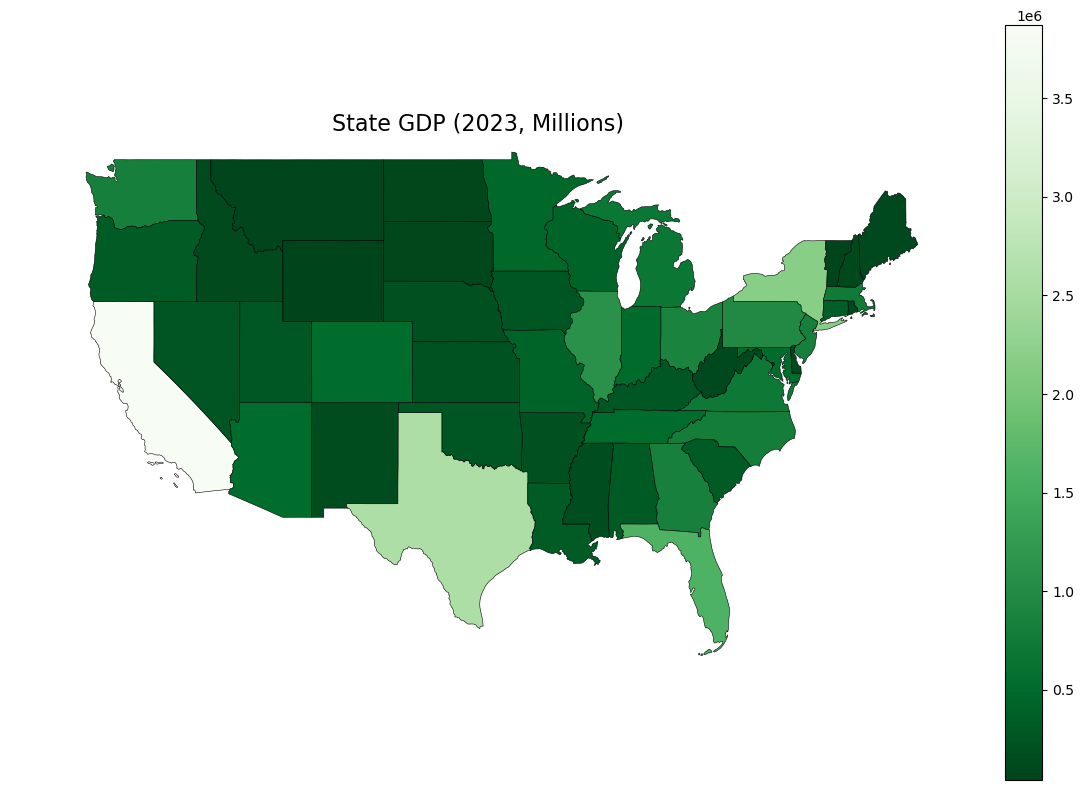

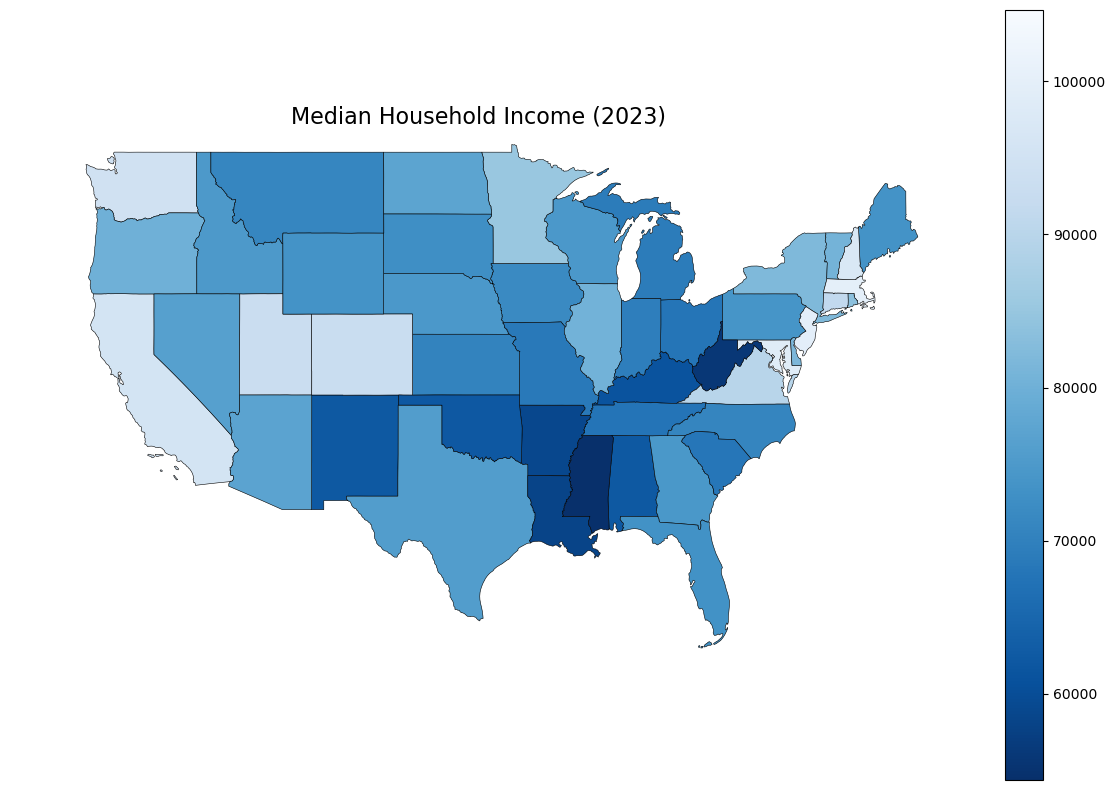

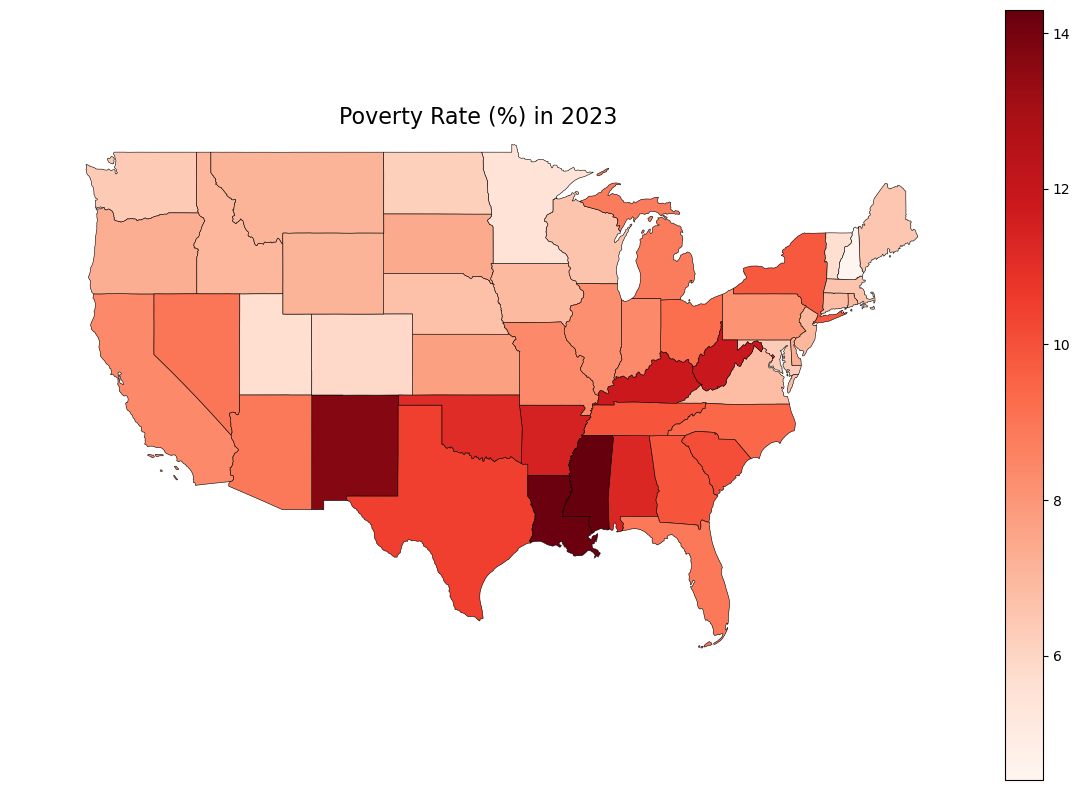

In [12]:
plot_choropleth(gdf_merged, 'GDP_2023_Million', 'State GDP (2023, Millions)', cmap='Greens_r')
plot_choropleth(gdf_merged, 'Median_Income_2023', 'Median Household Income (2023)', cmap='Blues_r')
plot_choropleth(gdf_merged, 'Poverty_Rate_Percent', 'Poverty Rate (%) in 2023', cmap='Reds')

# Load Balances

In [13]:
fips_to_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA',
    '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL',
    '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN',
    '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS',
    '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND',
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT',
    '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI',
    '56': 'WY'
}

In [14]:
nfip_balances = pd.read_csv("Results/state_balance_block.csv")
nfip_balances["STATEFP"] = nfip_balances["STATEFP"].astype(str).str.zfill(2)
nfip_balances["state_abbrev"] = nfip_balances["STATEFP"].map(fips_to_abbrev)

In [15]:
"""# Pivot the data to get a multivariate time series format
multivariate_nfip = nfip_balances.pivot_table(
    index="year",         # rows = years
    columns="state_abbrev",    # columns = state FIPS
    values="nfip_balance",  # values = balance
    aggfunc="sum",        # or 'mean' if multiple entries per year-state
    fill_value=0          # fill missing with 0
)"""

'# Pivot the data to get a multivariate time series format\nmultivariate_nfip = nfip_balances.pivot_table(\n    index="year",         # rows = years\n    columns="state_abbrev",    # columns = state FIPS\n    values="nfip_balance",  # values = balance\n    aggfunc="sum",        # or \'mean\' if multiple entries per year-state\n    fill_value=0          # fill missing with 0\n)'

In [16]:
# Get list of unique simulations
simulations = nfip_balances['simulation'].unique()
# Drop rows with missing state_abbrev (which maps from STATEFP)
nfip_balances = nfip_balances.dropna(subset=['state_abbrev'])

# Ensure all state abbreviations are strings and sort
nfip_balances['state_abbrev'] = nfip_balances['state_abbrev'].astype(str)
states = sorted(nfip_balances['state_abbrev'].unique())

# Initialize dictionary to track cluster assignments across simulations
cluster_records = defaultdict(list)

if simulate:
    # Loop through each simulation
    for sim in tqdm(simulations, desc="Clustering simulations"):
    
        # Subset the simulation
        df_sim = nfip_balances[nfip_balances['simulation'] == sim]
    
        # Pivot to wide format: rows = years, columns = states
        pivot_df = df_sim.pivot_table(
            index='year',
            columns='state_abbrev',
            values='nfip_balance',
            fill_value=0
        )
    
        # Normalize each state (column-wise)
        normalized = StandardScaler().fit_transform(pivot_df)
        normalized_df = pd.DataFrame(normalized, index=pivot_df.index, columns=pivot_df.columns)
    
        # Transpose: rows = states, columns = time series
        data = normalized_df.T.values
    
        # Compute DTW distances
        dtw_distances = cdist_dtw(data)
    
        # Hierarchical clustering
        condensed_dist = squareform(dtw_distances)
        Z = linkage(condensed_dist, method='average')
    
        # Choose number of clusters
        k = 6
        labels = fcluster(Z, k, criterion='maxclust')
    
        # Save each state's label for this simulation
        for state, cluster_label in zip(normalized_df.columns, labels):
            cluster_records[state].append(cluster_label)

    df_wide = pd.DataFrame(cluster_records)
    df_wide = df_wide.T  # states as rows
    df_wide.columns = [f"sim_{i}" for i in range(df_wide.shape[1])]
    df_wide.index.name = "state"
    df_wide.reset_index(inplace=True)
    
    df_wide.to_csv("Results/DTW_HC_simulation_clusters.csv", index=False)

else:
    df_wide = pd.read_csv("Results/DTW_HC_simulation_clusters4.csv")
    # Set 'state' as index so rows are states, columns are simulations
    df_wide_indexed = df_wide.set_index("state")

    # Convert each row to a list of cluster labels
    cluster_records = df_wide_indexed.apply(lambda row: row.tolist(), axis=1).to_dict()

In [17]:
# Assuming you already built cluster_records[state] = list of clusters from previous step
states = sorted(cluster_records.keys())
state_idx = {state: i for i, state in enumerate(states)}
n_states = len(states)
n_sims = len(next(iter(cluster_records.values())))

# Step 1: Build co-association matrix
coassoc_matrix = np.zeros((n_states, n_states))

for sim in tqdm(range(n_sims), desc="Building co-association matrix"):
    # Reconstruct clustering for this simulation
    sim_labels = {state: cluster_records[state][sim] for state in states}
    
    for i, state_i in enumerate(states):
        for j, state_j in enumerate(states):
            if sim_labels[state_i] == sim_labels[state_j]:
                coassoc_matrix[i, j] += 1

# Normalize to [0,1]
coassoc_matrix /= n_sims

# Step 2: Convert to dissimilarity matrix
dissimilarity = 1 - coassoc_matrix

# Step 3: Hierarchical clustering on dissimilarity
Z = linkage(dissimilarity, method='average')

# Choose number of consensus clusters
k = 3
final_labels = fcluster(Z, k, criterion='maxclust')

# Output DataFrame
cluster_df = pd.DataFrame({
    'state': states,
    'consensus_cluster': final_labels
})

Building co-association matrix: 100%|██████████| 1000/1000 [00:01<00:00, 691.24it/s]
/tmp/ipykernel_705/4283348117.py:26: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dissimilarity, method='average')


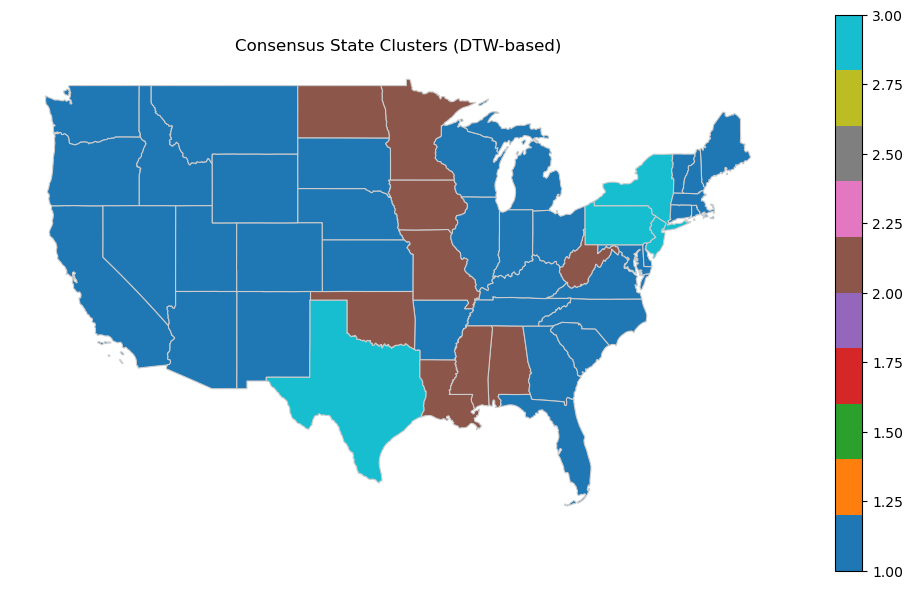

In [18]:
# Merge consensus clusters into GeoDataFrame
gdf_plot = gdf_states.copy()
gdf_plot = gdf_plot.merge(cluster_df, left_on="STUSPS", right_on="state", how="left")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf_plot.plot(column='consensus_cluster', cmap='tab10', linewidth=0.8,
              ax=ax, edgecolor='0.8', legend=True)
ax.set_title("Consensus State Clusters (DTW-based)")
ax.axis("off")
plt.tight_layout()
plt.show()

/tmp/ipykernel_705/1839407748.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Pastel2", len(unique_clusters))


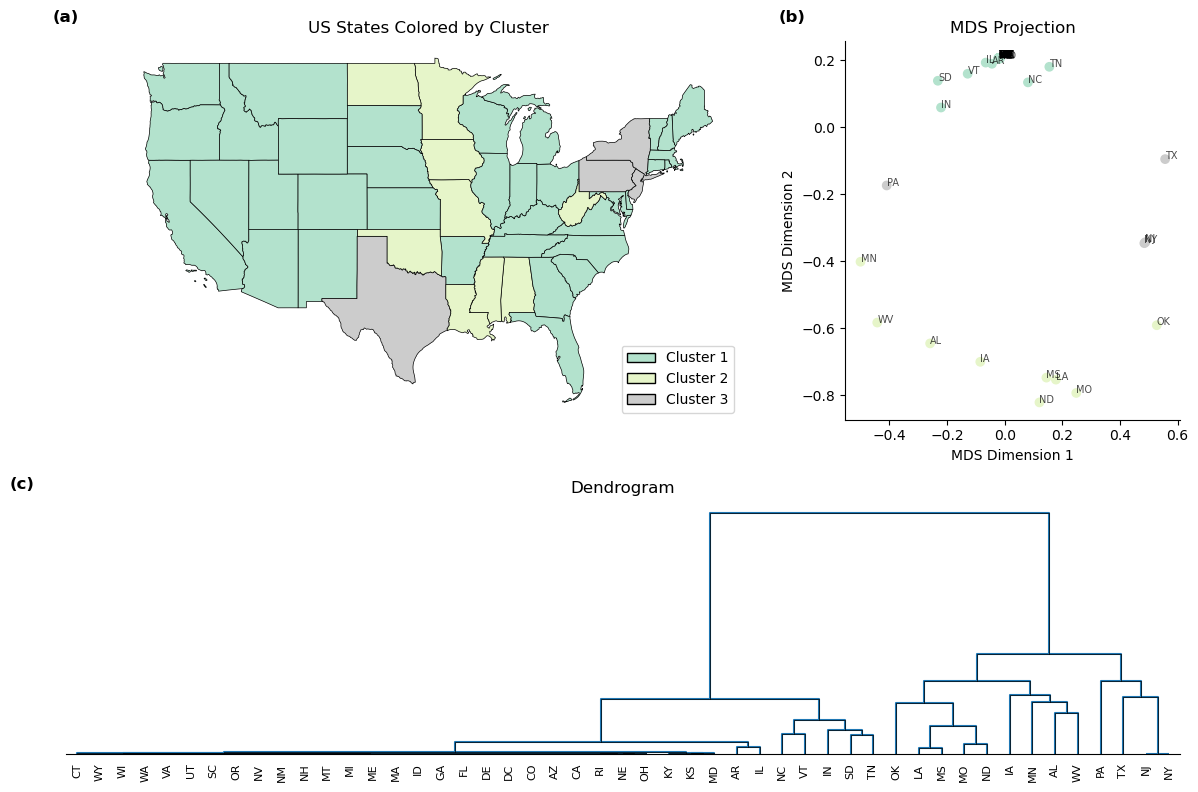

In [19]:
# Ensure column name is consistent for merge
cluster_df = cluster_df.rename(columns={"consensus_cluster": "cluster"})

# Merge into GeoDataFrame
gdf_plot = gdf_states.copy()
gdf_plot = gdf_plot.merge(cluster_df, left_on="STUSPS", right_on="state", how="left")

# ───── Panel: MDS projection ─────
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
coords = mds.fit_transform(1 - coassoc_matrix)

mds_df = pd.DataFrame(coords, columns=["MDS1", "MDS2"])
mds_df["cluster"] = cluster_df["cluster"].values
mds_df["label"] = cluster_df["state"].values

# ───── Set up figure layout ─────
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 2], width_ratios=[1, 1, 1])

# ───── Panel (a): Map ─────
ax_map = fig.add_subplot(gs[0, 0:2])
map_plot = gdf_plot.plot(
    column="cluster", cmap="Pastel2", ax=ax_map, edgecolor="black", linewidth=0.5,
    legend=False
)
ax_map.set_title("US States Colored by Cluster")
ax_map.axis("off")
ax_map.text(-0.1, 1.05, "(a)", transform=ax_map.transAxes, fontsize=12, fontweight='bold')

# Manual legend
unique_clusters = sorted(gdf_plot["cluster"].dropna().unique())
cmap = plt.cm.get_cmap("Pastel2", len(unique_clusters))
legend_elements = [
    Patch(facecolor=cmap(i), edgecolor='black', label=f'Cluster {int(c)}')
    for i, c in enumerate(unique_clusters)
]
ax_map.legend(handles=legend_elements, loc="lower right")

# ───── Panel (b): MDS projection ─────
ax_mds = fig.add_subplot(gs[0, 2])
scatter = ax_mds.scatter(mds_df["MDS1"], mds_df["MDS2"], c=mds_df["cluster"], cmap="Pastel2")
for _, row in mds_df.iterrows():
    ax_mds.text(row["MDS1"], row["MDS2"], row["label"], fontsize=7, alpha=0.7)
ax_mds.set_title("MDS Projection")
ax_mds.spines[['top', 'right']].set_visible(False)
ax_mds.set_xlabel("MDS Dimension 1")
ax_mds.set_ylabel("MDS Dimension 2")
ax_mds.text(-0.2, 1.05, "(b)", transform=ax_mds.transAxes, fontsize=12, fontweight='bold')

# ───── Panel (c): Dendrogram ─────
ax_dendro = fig.add_subplot(gs[1, :])
d = dendrogram(Z, labels=states, leaf_rotation=90, ax=ax_dendro, color_threshold=0)

# Make all dendrogram lines black and thin
for icoord, dcoord in zip(d['icoord'], d['dcoord']):
    ax_dendro.plot(icoord, dcoord, color='black', linewidth=0.5)

ax_dendro.set_title("Dendrogram")
ax_dendro.spines[['top', 'right', 'left']].set_visible(False)
ax_dendro.yaxis.set_ticks([])
ax_dendro.set_yticklabels([])
ax_dendro.text(-0.05, 1.05, "(c)", transform=ax_dendro.transAxes, fontsize=12, fontweight='bold')

# ───── Finalize Layout ─────
plt.tight_layout()

# Optional: Save
if save:
    plt.savefig("Plots/New/DTW_Clustering_block.png", dpi=500)
plt.show()